<a href="https://colab.research.google.com/github/cdkontos/MSC-DWS-Machine-Learning-Course-Exercises/blob/main/Exercise_3_Ensemble_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import plotly.express as px
import yfinance as yf
import plotly.graph_objects as go
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor

# Question 1

## Load Dataset

In [2]:
ticker_symbol = "DX-Y.NYB"
ticker = yf.Ticker(ticker_symbol)
df = ticker.history(period="5y").reset_index(drop=False)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-11-05 00:00:00-05:00,93.339996,93.550003,92.489998,92.529999,0,0.0,0.0
1,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003,0,0.0,0.0
2,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003,0,0.0,0.0
3,2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000,0,0.0,0.0
4,2020-11-11 00:00:00-05:00,92.699997,93.209999,92.610001,93.040001,0,0.0,0.0
...,...,...,...,...,...,...,...,...
1253,2025-10-30 00:00:00-04:00,99.139999,99.720001,98.919998,99.529999,0,0.0,0.0
1254,2025-10-31 00:00:00-04:00,99.489998,99.839996,99.419998,99.800003,0,0.0,0.0
1255,2025-11-03 00:00:00-05:00,99.750000,99.989998,99.709999,99.870003,0,0.0,0.0
1256,2025-11-04 00:00:00-05:00,99.980003,100.260002,99.739998,100.220001,0,0.0,0.0


## Drop Volume, Dividends and Stock Splits Columns

In [3]:
df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)
df

,Date,Open,High,Low,Close
0,2020-11-05 00:00:00-05:00,93.339996,93.550003,92.489998,92.529999
1,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003
2,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003
3,2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000
4,2020-11-11 00:00:00-05:00,92.699997,93.209999,92.610001,93.040001
...,...,...,...,...,...
1253,2025-10-30 00:00:00-04:00,99.139999,99.720001,98.919998,99.529999
1254,2025-10-31 00:00:00-04:00,99.489998,99.839996,99.419998,99.800003
1255,2025-11-03 00:00:00-05:00,99.750000,99.989998,99.709999,99.870003
1256,2025-11-04 00:00:00-05:00,99.980003,100.260002,99.739998,100.220001


## Line Plot with Plotly Library

In [4]:
figure = go.Figure()
figure.add_trace(go.Scatter(x=df['Date'], y=df['Open'], name='Open'))
figure.add_trace(go.Scatter(x=df['Date'], y=df['High'], name='High'))
figure.add_trace(go.Scatter(x=df['Date'], y=df['Low'], name='Low'))
figure.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close'))

figure.update_layout(title="USD Price Over Time", xaxis_title="Date", yaxis_title="Price", height=600)
figure.show()

# Question 2

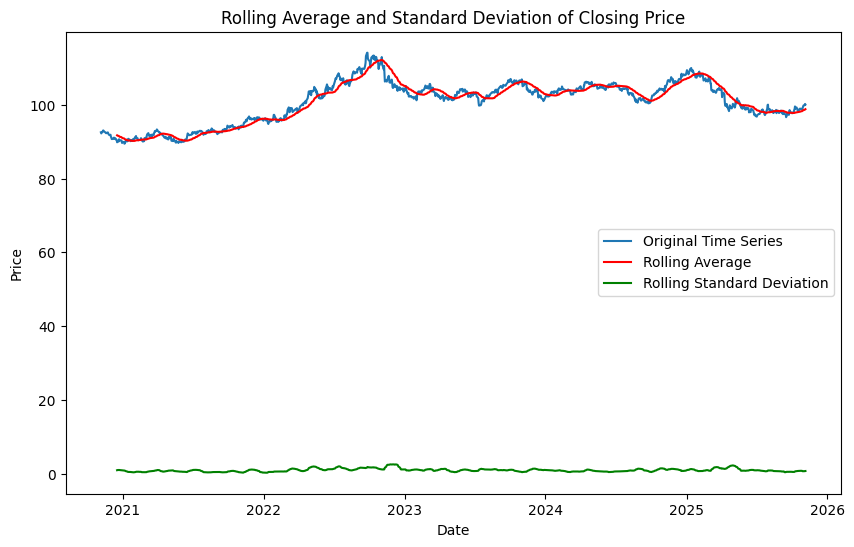

In [5]:
rolling_average = df['Close'].rolling(window=30).mean()
rolling_std = df['Close'].rolling(window=30).std()

plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'], label='Original Time Series')
plt.plot(df['Date'], rolling_average, label='Rolling Average', color='red')
plt.plot(df['Date'], rolling_std, label='Rolling Standard Deviation', color='green')
plt.title('Rolling Average and Standard Deviation of Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Close'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
 print('Critial Values:')
 print(f' {key}, {value}')

ADF Statistic: -1.7076966678756256
n_lags: 0.42715134874074767
p-value: 0.42715134874074767
Critial Values:
 1%, -3.435571295403709
Critial Values:
 5%, -2.863845736356174
Critial Values:
 10%, -2.567997600196822


To have stationarity the statistical properties of a time series, like the mean and standard deviation, need to not be dependant on the time and stay unchanged with it. As is visible from the figure, where the rolling average and rolling standard deviation show great variance as time goes on, as well as the high p_value from the ADF test, this time series is non-stationary.

# Question 3

Some of the problems that could arise if a regressor is trained on a non-stationary time series could be the following:


1.   Volatility in the market such as sudden crises or policy changes would make predictions unreliable if the model considers these as a pattern or some kind of trend.
2.   The regressor might confuse long term trends with real relationships in the data and provide false predictions.
3.   A concept drift might happen where, over time, the relationships between some variables might be completely different than before, thus making a model trained on them unreliable and inaccurate. These could be the USD price with prices of other currencies or other commodities like gold or oil.



# Question 4

In [7]:
june_2025_data = df[(df['Date'] >= '2025-06-01') & (df['Date'] <= '2025-06-30')]
july_2025_data = df[(df['Date'] >= '2025-07-01') & (df['Date'] <= '2025-07-31')]
june_ticks = pd.date_range('2025-06-01', '2025-06-30', freq='3D')
july_ticks = pd.date_range('2025-07-01', '2025-07-31', freq='3D')
figJune = go.Figure()
for col in ['Close']:
    if col in df.columns:
        figJune.add_trace(go.Scatter(x=june_2025_data['Date'], y=june_2025_data[col], mode='lines+markers', name=col))
figJune.update_layout(title='USD Close — June 2025', width=1000, height=450, xaxis_title='Date', yaxis_title='Price', xaxis=dict(tickmode='array', tickvals=june_ticks, tickformat='%b %d', tickangle=45))
figJune.show()
figJuly = go.Figure()
for col in ['Close']:
    if col in df.columns:
        figJuly.add_trace(go.Scatter(x=july_2025_data['Date'], y=july_2025_data[col], mode='lines+markers', name=col))
figJuly.update_layout(title='USD Close — July 2025', width=1000, height=450, xaxis_title='Date', yaxis_title='Price', xaxis=dict(tickmode='array', tickvals=july_ticks, tickformat='%b %d', tickangle=45))
figJuly.show()

In June of 2025 a downward trend can be observed in the dollar price with the price lowering from 98.7 to 96.88 from the start to the end of the month.
This could be due to the following reasons:


1.   Heightened fiscal and policy-uncertainty in the U.S., including concerns about large spending/tax bills and rising debt, which weighed on confidence in the dollar.
2.   Geopolitical or market-sentiment relief (for instance easing in Middle East tensions) reducing safe-haven demand for the dollar.
3.   Technical bearish momentum and structural vulnerabilities (e.g., the dollar breaking down from a bearish technical pattern).
4.   Relative strength in other currencies (or weakening of the U.S. economy) making the dollar less attractive.

Meanwhile, in July of 2025 an upward tred can be noticed as the dollar price gets raised from 96.82 to 100.03 from the start to the end of the month.
This could be due to the following reasons:


1.   Renewed indications that the Federal Reserve might hold interest rates higher for longer (or delay cuts), supporting the dollar's yield advantage.
2.   Trump's aggressive stance on tariffs injects policy uncertainty, which typically favors the USD as a reserve currency.
3.   A shift in trade-oriented or geopolitical news that favoured the dollar (for example, trade agreements or policy clarity) improving sentiment toward U.S. assets.


# Question 5

We can predict the dollar close price for the next day if we have as information the open, close, high, and low prices for today, but it will have limited accuracy due to the lack of available data for the prediction. The following function $$ f(o_t, h_t, l_t, c_t) = c_{t+1} $$
could be used to determine correlations, but since the price can be affected by various external factors and past data, it would be preferable to utilize data from a larger time range, such as multiple days or months, using timeframes, for more accurate predictions and favorable results.

# Question 6

The random split of the data set in train-test sets would be meaningless in the case of a time series for the following reasons:


1.   In time series the chronological order of the data is extremely important as each piece of data depends on the previous values and the prediction is based on how that value evolves over time.
2.   If a random split does happen the data would be trained on values from different times thus creating a flawed model that would try to predict, for example, a past value using data from the future.
3.   It is important to train the model on older data and to test it on newer data in order to simulate its real world use as it will always accept older data in order to predict future values.





# Question 7

In [8]:
train_df = df[df['Date'] < '2024-01-01 00:00:00'].drop(columns=['Date'])
test_df = df[(df['Date'] >= '2024-01-01 00:00:00') & (df['Date'] < '2025-01-01 00:00:00')].drop(columns=['Date'])

train_df.shape, test_df.shape

((792, 4), (252, 4))

# Question 8

In [9]:
def create_timeframes(dataframe, timeframe=5):
    x, y = [], []
    for i in range(len(dataframe) - timeframe):
        x.append(dataframe.iloc[i:i+timeframe][['Open', 'High', 'Low', 'Close']].values)
        y.append(dataframe.iloc[i+timeframe]['Close'])
    return np.array(x), np.array(y)

# Question 9

To predict the close price for the following day, the size of timeframe N should be relatively small, with 3 to 5 days being an appropriate number. This small number of days is enough for this prediction as it takes into account the most recent values and does not get affected by older ones that could be considered noise the further back it goes. On the other hand, in order to predict the furthest horizon, such as a month, a the size of the timeframe would have to become larger to around 20 to 30 days as a larger amount of data would be needed to make that prediction more accurately, by taking into account the trends and the patterns that might exist in the data.

# Question 10

In [10]:
x_train, y_train = create_timeframes(train_df, 5)
x_test, y_test = create_timeframes(test_df, 5)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((787, 5, 4), (787,), (247, 5, 4), (247,))

In [11]:
n = 5
num_features = train_df.shape[1]


x_train_flat = x_train.reshape((x_train.shape[0], n*num_features))
x_test_flat = x_test.reshape((x_test.shape[0], n*num_features))
print("x_train shape:", x_train_flat.shape)
print("y_train shape:", y_train.shape)
print("First input of x_train:", x_train_flat[0])

x_train shape: (787, 20)
y_train shape: (787,)
First input of x_train: [93.33999634 93.55000305 92.48999786 92.52999878 92.56999969 92.81999969
 92.18000031 92.23000336 92.23999786 92.95999908 92.12999725 92.73000336
 92.76000214 92.97000122 92.59999847 92.75       92.69999695 93.20999908
 92.61000061 93.04000092]


# Question 11

## Linear Regression

In [12]:
linear_model = LinearRegression()
linear_model.fit(x_train_flat, y_train)
y_pred_train_linear = linear_model.predict(x_train_flat)
y_pred_test_linear = linear_model.predict(x_test_flat)

mae_train_linear = mean_absolute_error(y_train, y_pred_train_linear)
mae_test_linear = mean_absolute_error(y_test, y_pred_test_linear)
print(f"Linear Regression - MAE Train: {mae_train_linear}, MAE Test: {mae_test_linear}")

Linear Regression - MAE Train: 0.34536750446372355, MAE Test: 0.28457953197664765


## Random Forest Regressor

In [13]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(x_train_flat, y_train)
y_pred_train_rf = random_forest_model.predict(x_train_flat)
y_pred_test_rf = random_forest_model.predict(x_test_flat)

mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
print(f"Random Forest Regressor - MAE Train: {mae_train_rf}, MAE Test: {mae_test_rf}")

Random Forest Regressor - MAE Train: 0.14551381122051069, MAE Test: 0.3229283256376322


## Bagging using Linear Regression as estimator

In [14]:
bagging_model = BaggingRegressor(estimator=linear_model, n_estimators=10)
bagging_model.fit(x_train_flat, y_train)
y_pred_train_bagging = bagging_model.predict(x_train_flat)
y_pred_test_bagging = bagging_model.predict(x_test_flat)

mae_train_bagging = mean_absolute_error(y_train, y_pred_train_bagging)
mae_test_bagging = mean_absolute_error(y_test, y_pred_test_bagging)
print(f"Bagging with Linear Regression as estimator - MAE Train: {mae_train_bagging}, MAE Test: {mae_test_bagging}")

Bagging with Linear Regression as estimator - MAE Train: 0.3463172944200492, MAE Test: 0.2826627176687729


## Boosting with XGBoost

In [15]:
xgboost_model = XGBRegressor()
xgboost_model.fit(x_train_flat, y_train)
y_pred_train_xgb = xgboost_model.predict(x_train_flat)
y_pred_test_xgb = xgboost_model.predict(x_test_flat)

mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
mae_test_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
print(f"XGBoost - MAE Train: {mae_train_xgb}, MAE Test: {mae_test_xgb}")

XGBoost - MAE Train: 0.02159788526755579, MAE Test: 0.3802515871611684


## Stacking using Linear Regression and Decision Tree Regression as estimators

In [16]:
stacking_model = StackingRegressor(estimators=[('ln', linear_model), ('dt', DecisionTreeRegressor())])
stacking_model.fit(x_train_flat, y_train)
y_pred_train_stacking = stacking_model.predict(x_train_flat)
y_pred_test_stacking = stacking_model.predict(x_test_flat)

mae_train_stacking = mean_absolute_error(y_train, y_pred_train_stacking)
mae_test_stacking = mean_absolute_error(y_test, y_pred_test_stacking)
print(f"Stacking with Linear Regression and Decision Tree Regression as estimators - MAE Train: {mae_train_stacking}, MAE Test: {mae_test_stacking}")

Stacking with Linear Regression and Decision Tree Regression as estimators - MAE Train: 0.354394814104502, MAE Test: 0.28715897489805836


In [17]:
models = ['Linear', 'RandomForest ', 'Bagging', 'XGBoost', 'Stacking']
mae_train = [mae_train_linear, mae_train_rf, mae_train_bagging, mae_train_xgb, mae_train_stacking]
mae_test = [mae_test_linear, mae_test_rf, mae_test_bagging, mae_test_xgb, mae_test_stacking]

fig_bar = go.Figure()
fig_bar.add_trace(go.Bar(x=models, y=mae_train, name='Train Mae', marker_color='blue'))
fig_bar.add_trace(go.Bar(x=models, y=mae_test, name='Test Mae', marker_color='green'))
fig_bar.update_layout(title='MAE Comparison', xaxis_title='Models', yaxis_title='MAE', barmode='group', width=1000, height=500)
fig_bar.show()

The models that were used are explained in the following:

*   Linear Regression assumes a linear relationship between the input features and the target, estimating coefficients that minimize the sum of squared errors.
*   Random Forest Regressor is an ensemble of many decision trees trained on different random subsets of the data and features with their averaged predictions reducing variance and improving generalization.
*   Bagging is a method that creates multiple bootstrap samples of the training set, fits a Linear Regression model on each, and averages their predictions for more stable results.
*   XGBoost is a gradient boosting algorithm that builds trees sequentially, where each new tree corrects the errors of the previous ones, optimizing a loss function efficiently.
*   Stacking is a method that combines predictions from multiple base models (e.g., Linear Regression and Decision Tree in this case) using a meta-model that learns how to best weight their outputs for improved accuracy.

# Question 12

## Add Month and Day as feature

In [18]:
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Month'] = (df['Month'] - 1) / 11
df['Day'] = df['Date'].dt.day / df['Date'].dt.days_in_month
df.dropna(inplace=True)
df

,Date,Open,High,Low,Close,Month,Day
0,2020-11-05 00:00:00-05:00,93.339996,93.550003,92.489998,92.529999,0.909091,0.166667
1,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003,0.909091,0.200000
2,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003,0.909091,0.300000
3,2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000,0.909091,0.333333
4,2020-11-11 00:00:00-05:00,92.699997,93.209999,92.610001,93.040001,0.909091,0.366667
...,...,...,...,...,...,...,...
1253,2025-10-30 00:00:00-04:00,99.139999,99.720001,98.919998,99.529999,0.818182,0.967742
1254,2025-10-31 00:00:00-04:00,99.489998,99.839996,99.419998,99.800003,0.818182,1.000000
1255,2025-11-03 00:00:00-05:00,99.750000,99.989998,99.709999,99.870003,0.909091,0.100000
1256,2025-11-04 00:00:00-05:00,99.980003,100.260002,99.739998,100.220001,0.909091,0.133333


Adding the month and the day as features helps add seasonality in the time series, such as the trend of the dollar going up or down on specific months or dates, due to, for example, tourism or trade cycles, which helps the models with recognizing seasonal patterns and thus provide more accurate predictions.

## Log Returns

In [19]:
for col in ['Open', 'High', 'Low', 'Close']:
    df[f'Log_Returns_{col}'] = np.log(df[col] / df[col].shift(1))
df

,Date,Open,High,Low,Close,Month,Day,Log_Returns_Open,Log_Returns_High,Log_Returns_Low,Log_Returns_Close
0,2020-11-05 00:00:00-05:00,93.339996,93.550003,92.489998,92.529999,0.909091,0.166667,NaN,NaN,NaN,NaN
1,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003,0.909091,0.200000,-0.008284,-0.007834,-0.003357,-0.003247
2,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003,0.909091,0.300000,-0.003571,0.001507,-0.000543,0.005407
3,2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000,0.909091,0.333333,0.005622,0.000108,0.005089,0.000216
4,2020-11-11 00:00:00-05:00,92.699997,93.209999,92.610001,93.040001,0.909091,0.366667,-0.000647,0.002578,0.000108,0.003122
...,...,...,...,...,...,...,...,...,...,...,...
1253,2025-10-30 00:00:00-04:00,99.139999,99.720001,98.919998,99.529999,0.818182,0.967742,0.004043,0.003617,0.003037,0.003119
1254,2025-10-31 00:00:00-04:00,99.489998,99.839996,99.419998,99.800003,0.818182,1.000000,0.003524,0.001203,0.005042,0.002709
1255,2025-11-03 00:00:00-05:00,99.750000,99.989998,99.709999,99.870003,0.909091,0.100000,0.002610,0.001501,0.002913,0.000701
1256,2025-11-04 00:00:00-05:00,99.980003,100.260002,99.739998,100.220001,0.909091,0.133333,0.002303,0.002697,0.000301,0.003498


## Histogram for each column

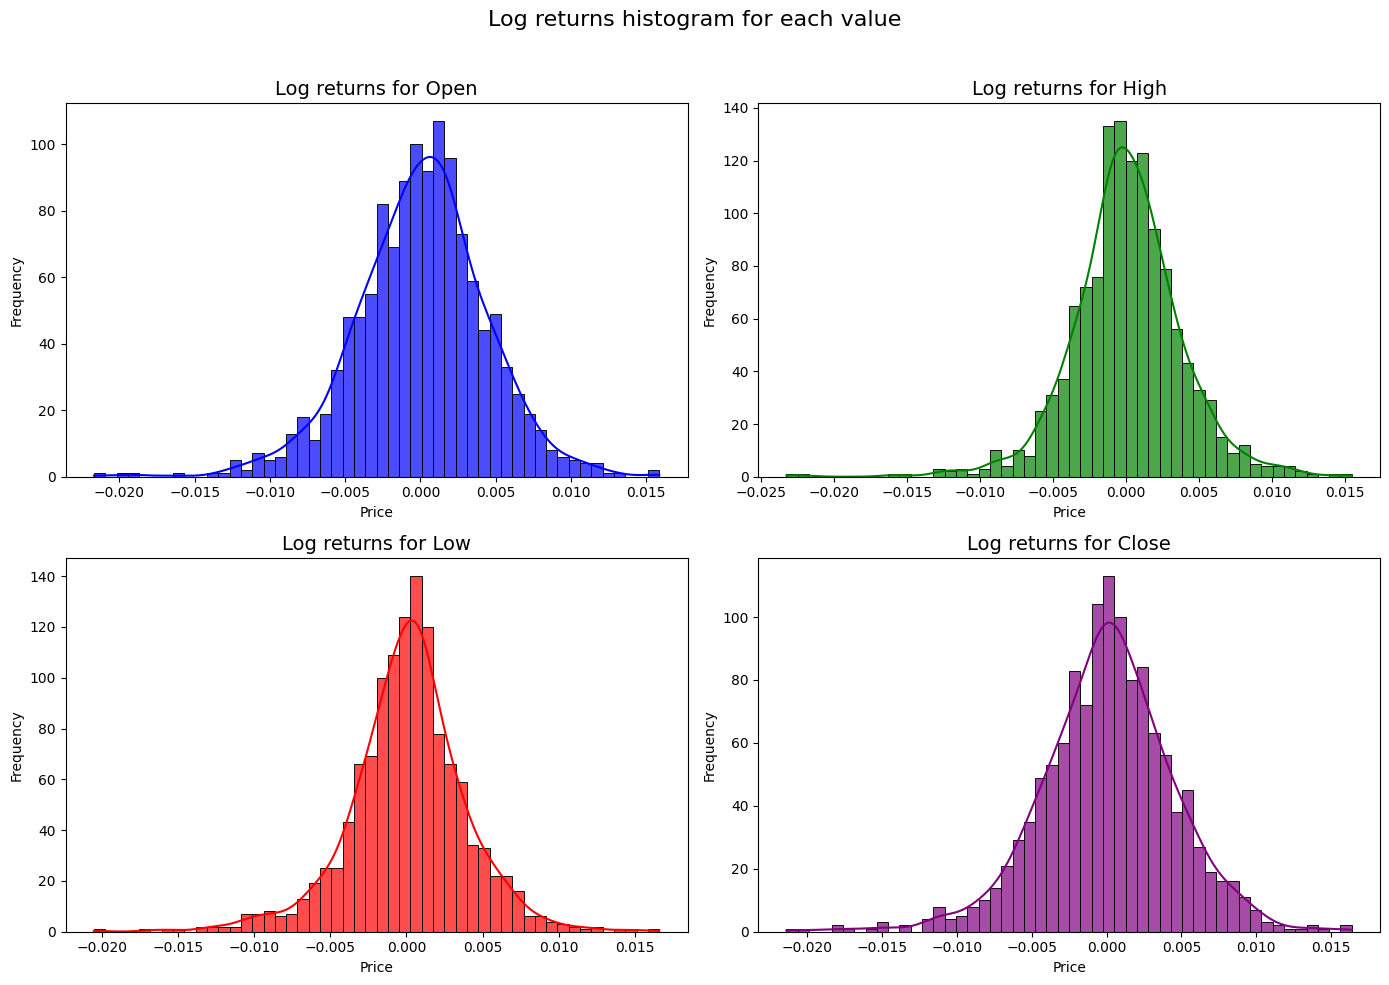

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Log returns histogram for each value', fontsize=16)

columns = ['Log_Returns_Open', 'Log_Returns_High', 'Log_Returns_Low', 'Log_Returns_Close']
titles = ['Open', 'High', 'Low', 'Close']
colors = ['blue', 'green', 'red', 'purple']

for i, ax in enumerate(axes.flatten()):
    sns.histplot(df[columns[i]].dropna(), bins=50, kde=True, color=colors[i], ax=ax, edgecolor="k", alpha=0.7)
    ax.set_title(f'Log returns for {titles[i]}', fontsize=14)
    ax.set_xlabel('Price')
    ax.set_ylabel('Frequency')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The use of log returns can halp improve the model predictions by stabilizing the variance, normalizing relative changes and reducing the impact of extreme values, thus allowing models to better focus on discovering patterns and trends and as a result provide higher prediction accuracy.

## Price Prediction Analysis

The price
$$  C_{t+1} = 0.01 $$

represents the expected log return between the close prices at the times t and t+1

In order to calculate the absolute value of

$$ C_{t+1}  $$

we can use the reverse formula:

$$
[
C_{t+1} = C_t \times e^{C_{t+1}}
]
$$

In [21]:
C_t = 0.95
log_return_prediction = 0.01
C_t_plus_1 = C_t * np.exp(log_return_prediction)
print(f'The predicted close price for the next day is: {C_t_plus_1}')

The predicted close price for the next day is: 0.9595476587299595


## Feature Preparation

In [22]:
train = df[df['Date'] < '2024-01-01 00:00:00'].reset_index(drop=True)
test = df[(df['Date'] >= '2024-01-01 00:00:00') & (df['Date'] < '2025-01-01 00:00:00')].reset_index(drop=True)

for col in ['Open', 'High', 'Low', 'Close']:
    train[f'Log_Returns_{col}'] = np.log(train[col] / (train[col].shift(1)))
    test[f'Log_Returns_{col}'] = np.log(test[col] / (test[col].shift(1)))

train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [23]:
def create_timeframes(dataframe, timeframe=5):
    x, y, y_dates, C_t = [], [], [], []
    features = ['Open', 'High', 'Low', 'Close', 'Month'] + [f'Log_Returns_{col}' for col in ['Open', 'High', 'Low', 'Close']]
    for i in range(len(dataframe) - timeframe):
        x.append(dataframe.iloc[i:i+timeframe][features].values)
        y.append(dataframe.iloc[i+timeframe]['Close'])
        y_dates.append(dataframe.iloc[i+timeframe]['Date'])
        C_t.append(dataframe.iloc[i+timeframe - 1]['Close'])
    return np.array(x), np.array(y), y_dates, np.array(C_t)

In [24]:
x_train, y_train, y_train_dates, C_t_train = create_timeframes(train, timeframe=5)
x_test, y_test, y_test_dates, C_t_test = create_timeframes(test, timeframe=5)
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))
x_train.shape, x_test.shape

((787, 45), (247, 45))

## New Models

### Linear Regression

In [25]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

mae_train_linear = mean_absolute_error(y_train, linear_model.predict(x_train))
mae_test_linear = mean_absolute_error(y_test, linear_model.predict(x_test))
print(f"Linear Regression - MAE Train: {mae_train_linear}, MAE Test: {mae_test_linear}")

Linear Regression - MAE Train: 0.340608675912919, MAE Test: 0.2972547000333426


### Random Forest Regressor

In [26]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(x_train, y_train)
y_pred_train_rf = random_forest_model.predict(x_train)
y_pred_test_rf = random_forest_model.predict(x_test)

mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
print(f"Random Forest Regressor - MAE Train: {mae_train_rf}, MAE Test: {mae_test_rf}")

Random Forest Regressor - MAE Train: 0.14540304394810447, MAE Test: 0.3207172338200001


### Bagging using Linear Regression as estimator

In [27]:
bagging_model = BaggingRegressor(estimator=linear_model, n_estimators=10)
bagging_model.fit(x_train, y_train)

mae_train_bagging = mean_absolute_error(y_train, bagging_model.predict(x_train))
mae_test_bagging = mean_absolute_error(y_test, bagging_model.predict(x_test))
print(f"Bagging Regressor - MAE Train: {mae_train_bagging}, MAE Test: {mae_test_bagging}")

Bagging Regressor - MAE Train: 0.3411500390388597, MAE Test: 0.296987685524271


### Boosting with XGBoost

In [28]:
xgboost_model = XGBRegressor()
xgboost_model.fit(x_train, y_train)

mae_train_xgb = mean_absolute_error(y_train, xgboost_model.predict(x_train))
mae_test_xgb = mean_absolute_error(y_test, xgboost_model.predict(x_test))
print(f"XGBoost Regressor - MAE Train: {mae_train_xgb}, MAE Test: {mae_test_xgb}")

XGBoost Regressor - MAE Train: 0.0014812270749781607, MAE Test: 0.36650839122200785


### Stacking using Linear Regression and Decision Tree Regression as estimators

In [29]:
stacking_model = StackingRegressor(estimators=[('ln', linear_model), ('dt', DecisionTreeRegressor())])
stacking_model.fit(x_train, y_train)
y_pred_train_stacking = stacking_model.predict(x_train)
y_pred_test_stacking = stacking_model.predict(x_test)

mae_train_stacking = mean_absolute_error(y_train, y_pred_train_stacking)
mae_test_stacking = mean_absolute_error(y_test, y_pred_test_stacking)
print(f"Stacking with Linear Regression and Decision Tree Regression as estimators - MAE Train: {mae_train_stacking}, MAE Test: {mae_test_stacking}")

Stacking with Linear Regression and Decision Tree Regression as estimators - MAE Train: 0.35306089613059105, MAE Test: 0.29873461388004846


## New Models Histogram

In [30]:
models = ['Linear', 'RandomForest ', 'Bagging', 'XGBoost', 'Stacking']
mae_train = [mae_train_linear, mae_train_rf, mae_train_bagging, mae_train_xgb, mae_train_stacking]
mae_test = [mae_test_linear, mae_test_rf, mae_test_bagging, mae_test_xgb, mae_test_stacking]

best_index = int(np.argmin(mae_test))
best_model_name = models[best_index]
fig_bar = go.Figure()
fig_bar.add_trace(go.Bar(x=models, y=mae_train, name='Train Mae', marker_color='blue'))
fig_bar.add_trace(go.Bar(x=models, y=mae_test, name='Test Mae', marker_color='green'))
fig_bar.update_layout(title='MAE Comparison', xaxis_title='Models', yaxis_title='MAE', barmode='group', width=1000, height=500)
fig_bar.show()
print(f"The best model is: {best_model_name} (Test MAE = {mae_test[best_index]:.4f})")

The best model is: Bagging (Test MAE = 0.2970)


# Question 13

In [31]:
y_pred = linear_model.predict(x_test)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=y_test_dates,
    y=y_test,
    mode='lines',
    name='Actual Close Prices',
    line=dict(color='blue', width=2)
))
fig.add_trace(go.Scatter(
    x=y_test_dates,
    y=y_pred,
    mode='lines',
    name='Predicted Close Prices',
    line=dict(color='red', width=2)
))
fig.update_layout(
    title='Actual vs. Predicted Close Prices',
    xaxis_title='Date',
    yaxis_title='Close Price',
    width=1000,
    height=500
)
fig.show()